# **Black-Scholes PINN Approximator**
In this notebook, I'll be approximating the **Black-Scholes** equation using a **Physics-Informed Neural Network** or **PINN**. This will be foundational for when we scale up to the **Heston Model**. We will also cross-validate the data in this notebook with the solution found in our RK4 numerical solver and the PINN will be optimized via a **Sweep**.



---

$$
\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS \frac{\partial V}{\partial S} - rV = 0
$$
<center>

**Black-Scholes PDE**
</center>

Where:
* $V$: Option price
* $t$: Time
* $S$: Price of the underlying asset
* $\sigma$: Volatility of the underlying asset's returns
* $r$: Risk-free interest rate

---



## **Initialize Model + Define Parameters**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Manually set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class BlackScholesPINN(nn.Module):
    def __init__(self, input_dim=2, output_dim=1, hidden_layers=4, neurons_per_layer=64, activation_fn=nn.Tanh()):
        super().__init__()
        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, neurons_per_layer))
        layers.append(activation_fn)

        # Hidden layers
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(activation_fn)

        # Output layer
        layers.append(nn.Linear(neurons_per_layer, output_dim))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Black-Scholes parameters (match with RK4 solver)
r = 0.05          # Risk-free rate
sigma = 0.2       # Volatility
K = 100           # Strike price
T = 1.0           # Time to maturity (in years)
S_max = 250       # Max stock price in spatial domain
S_min = 0         # Min stock price
N = 500           # Number of spatial grid points

# Create spatial grid
S = torch.linspace(S_min, S_max, N).view(-1, 1).requires_grad_()
t = torch.linspace(0, T, N).view(-1, 1).requires_grad_()


## **Define Losses**

In [7]:
def pde_loss(model, S, t):
    S.requires_grad_(True)
    t.requires_grad_(True)
    X = torch.cat((S, t), dim=1)
    V = model(X)

    V_t = torch.autograd.grad(V, t, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_S = torch.autograd.grad(V, S, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_SS = torch.autograd.grad(V_S, S, grad_outputs=torch.ones_like(V_S), create_graph=True)[0]

    residual = V_t + 0.5 * sigma**2 * S**2 * V_SS + r * S * V_S - r * V
    return torch.mean(residual.pow(2))


def boundary_loss(model, t):
    S0 = torch.zeros_like(t)
    S_high = torch.full_like(t, S_max)

    bc_low = model(torch.cat((S0, t), dim=1))
    bc_high = model(torch.cat((S_high, t), dim=1))
    expected_high = S_max - K * torch.exp(-r * (T - t))

    return torch.mean(bc_low.pow(2)) + torch.mean((bc_high - expected_high).pow(2))


def initial_loss(model, S):
    t0 = torch.zeros_like(S)
    X0 = torch.cat((S, t0), dim=1)

    V_pred = model(X0)
    V_true = torch.clamp(S - K, min=0.0)

    return torch.mean((V_pred - V_true).pow(2))


## **Training Loop**
Due to the complexity of this equation, we add in an adaptive stepper. After trial and error with different weights, it seemed like the next most important hyperparemeter to be tuned was the **learning rate**. I looked up various ways to do adaptive stepping and I stumbled across the **ReduceLROnPlateau** function within the PyTorch library. This function will monitor our total loss and reduce our learning rate when we begin to plateau.

In [8]:
# Initialize model, optimizer, and training parameters
model = BlackScholesPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

epochs = 10000
loss_history = []

# Weights for each loss component (tuned via trial and error)
pde_weight = 3.547
bc_weight = 1.854
ic_weight = 0.168

print(f'Weights - PDE: {pde_weight}, BC: {bc_weight}, IC: {ic_weight}')

# Adaptive learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=400, min_lr=1e-7, verbose=True)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    V = model(torch.cat((S, t), dim=1))

    # Compute losses
    pde_l = pde_loss(model, S, t)
    bc_l = boundary_loss(model, t)
    ic_l = initial_loss(model, S)
    total_loss = (pde_weight * pde_l) + (bc_weight * bc_l) + (ic_weight * ic_l)

    total_loss.backward()
    optimizer.step()

    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(total_loss)
    else:
        scheduler.step()

    loss_history.append(total_loss.item())
    current_lr = optimizer.param_groups[0]['lr']


    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.3f}, PDE Loss: {pde_l.item():.3f}, BC Loss: {bc_l.item():.3f}, IC Loss: {ic_l.item():.3f}, LR: {current_lr:.6f}')

Weights - PDE: 3.547, BC: 1.854, IC: 0.168
Epoch 0, Loss: 64.633, PDE Loss: 14.234, BC Loss: 7.627, IC Loss: 0.017, LR: 0.000500


c:\Users\tobys\miniconda3\envs\star-pinn\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 500, Loss: 3.855, PDE Loss: 0.633, BC Loss: 0.065, IC Loss: 8.871, LR: 0.000500
Epoch 1000, Loss: 1.598, PDE Loss: 0.164, BC Loss: 0.106, IC Loss: 4.873, LR: 0.000500
Epoch 1500, Loss: 0.721, PDE Loss: 0.078, BC Loss: 0.050, IC Loss: 2.096, LR: 0.000500
Epoch 2000, Loss: 0.456, PDE Loss: 0.057, BC Loss: 0.025, IC Loss: 1.227, LR: 0.000500
Epoch 2500, Loss: 0.372, PDE Loss: 0.046, BC Loss: 0.019, IC Loss: 1.035, LR: 0.000500
Epoch 3000, Loss: 0.331, PDE Loss: 0.041, BC Loss: 0.015, IC Loss: 0.941, LR: 0.000500
Epoch 3500, Loss: 0.306, PDE Loss: 0.038, BC Loss: 0.012, IC Loss: 0.876, LR: 0.000500
Epoch 4000, Loss: 0.286, PDE Loss: 0.036, BC Loss: 0.010, IC Loss: 0.824, LR: 0.000500
Epoch 4500, Loss: 0.268, PDE Loss: 0.034, BC Loss: 0.009, IC Loss: 0.773, LR: 0.000500
Epoch 5000, Loss: 0.251, PDE Loss: 0.033, BC Loss: 0.008, IC Loss: 0.717, LR: 0.000500
Epoch 5500, Loss: 0.235, PDE Loss: 0.031, BC Loss: 0.007, IC Loss: 0.665, LR: 0.000500
Epoch 6000, Loss: 0.182, PDE Loss: 0.022, BC

### **Plot Loss**

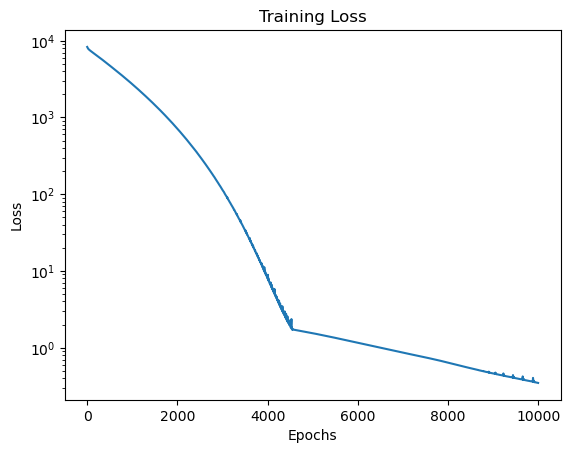

In [ ]:
plt.plot(loss_history)
plt.title('Training Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### **Sweep**

In [ ]:
import wandb
import math # For math.prod if needed for debugging


# --- IMPORTANT: Your PINN Model and Loss Functions ---
# Make sure your blackScholesPINN class, pde_loss, boundary_loss, initial_loss
# functions, and S, t tensors are defined in previous cells or imported.
# For example:
# from your_module import blackScholesPINN, pde_loss, boundary_loss, initial_loss, S, t
# If they are not globally available, you might need to pass them or define them inside train_pinn_sweep.
# For simplicity, this assumes they are already defined when this cell runs.

# Define the sweep configuration
# We'll use 'random' search to efficiently explore the weight space.
# The 'metric' defines what we are trying to optimize (minimize final_total_loss).
# 'parameters' define the ranges/distributions for the hyperparameters we want to tune.

sweep_config = {
    'method': 'bayes', # or 'grid' or 'bayes'
    'metric': {
        'name': 'final_total_loss',
        'goal': 'minimize'
    },
    'parameters': {
        # Initial Learning Rate (Still good to sweep, as it affects where scheduler starts)
        'initial_lr': {
            'min': 0.0001,
            'max': 0.005,
            'distribution': 'log_uniform_values' # Log uniform is good for LR
        },
        # Patience for LR scheduler (how long to wait before reducing)
        'lr_patience': {
            'min': 100,
            'max': 500,
            'distribution': 'int_uniform' # Integer values
        },
        # Factor for LR reduction (e.g., 0.1 for 10x, 0.5 for 2x)
        'lr_factor': {
            'min': 0.05,
            'max': 0.5,
            'distribution': 'uniform'
        },
        # Loss Weights - This is the core of this sweep
        # We'll define them as relative scales, then normalize in the training function
        # This allows you to explore their influence independently before normalizing.
        'pde_weight_scale': {
            'min': 0.01, # Min relative scale for PDE loss
            'max': 10.0, # Max relative scale for PDE loss (can go higher if PDE is very hard)
            'distribution': 'log_uniform_values'
        },
        'bc_weight_scale': {
            'min': 0.1, # Min relative scale for BC loss
            'max': 10.0, # Max relative scale for BC loss
            'distribution': 'log_uniform_values'
        },
        'ic_weight_scale': {
            'min': 0.1, # Min relative scale for IC loss
            'max': 10.0, # Max relative scale for IC loss
            'distribution': 'log_uniform_values'
        },
        # Network architecture (optional, but good to include in a later sweep)
        # 'hidden_layers': {
        #     'values': [4, 6, 8] # Number of hidden layers
        # },
        # 'neurons_per_layer': {
        #     'values': [64, 128, 256] # Number of neurons per layer
        # }
    }
}

# The training function that will be run by each sweep agent
def train_pinn_sweep():
    # Initialize a new W&B run for this trial
    wandb.init()

    # Access hyperparameters for the current run
    config = wandb.config

    # Normalize weights to sum to 1, or use them as raw scaling factors
    # It's often better to use them as raw scaling factors if you don't enforce a sum=1
    # and let the network decide which loss needs more attention.
    # If you want to enforce sum=1:
    # total_scale = config.pde_weight_scale + config.bc_weight_scale + config.ic_weight_scale
    # pde_weight = config.pde_weight_scale / total_scale
    # bc_weight = config.bc_weight_scale / total_scale
    # ic_weight = config.ic_weight_scale / total_scale
    # Or, use them directly as they are more like penalty terms:
    pde_weight = config.pde_weight_scale
    bc_weight = config.bc_weight_scale
    ic_weight = config.ic_weight_scale


    # Initialize model and optimizer with hyperparameters from config
    model = BlackScholesPINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.initial_lr)

    # Adaptive learning rate scheduler using config values
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=config.lr_factor,
        patience=config.lr_patience,
        min_lr=1e-7, # Keep a very low min_lr
        verbose=True
    )

    epochs = 10000 # Keep fixed for this sweep, or make it a sweep param too
    
    # Store individual loss components (optional but good for analysis)
    run_pde_loss_history = []
    run_bc_loss_history = []
    run_ic_loss_history = []
    run_total_loss_history = []

    print(f"Starting run with Weights: PDE={pde_weight:.2e}, BC={bc_weight:.2e}, IC={ic_weight:.2e}, "
          f"Initial LR={config.initial_lr:.2e}, Patience={config.lr_patience}, Factor={config.lr_factor:.2f}")

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Ensure S and t are on the correct device (e.g., GPU if available)
        # S = S.to(device)
        # t = t.to(device)
        V = model(torch.cat((S, t), dim=1))

        # Compute losses
        pde_l = pde_loss(model, S, t)
        bc_l = boundary_loss(model, t)
        ic_l = initial_loss(model, S)
        
        # Calculate total loss using the swept weights
        total_loss = (pde_weight * pde_l) + (bc_weight * bc_l) + (ic_weight * ic_l)

        total_loss.backward()
        optimizer.step()

        # Step the scheduler (pass total_loss for ReduceLROnPlateau)
        scheduler.step(total_loss)

        current_lr = optimizer.param_groups[0]['lr']

        # Log metrics to W&B for each epoch
        wandb.log({
            "epoch": epoch,
            "total_loss": total_loss.item(),
            "pde_loss": pde_l.item(),
            "bc_loss": bc_l.item(),
            "ic_loss": ic_l.item(),
            "learning_rate": current_lr,
            "bc_loss_norm_factor": bc_l.item() / (total_loss.item() + 1e-9), # Debugging loss contributions
            "ic_loss_norm_factor": ic_l.item() / (total_loss.item() + 1e-9)
        })

        run_total_loss_history.append(total_loss.item())
        run_pde_loss_history.append(pde_l.item())
        run_bc_loss_history.append(bc_l.item())
        run_ic_loss_history.append(ic_l.item())


        if epoch % 500 == 0 or epoch == epochs - 1: # Print at intervals and at the very end
            print(f'Epoch {epoch}, Total Loss: {total_loss.item():.6f}, '
                  f'PDE Loss: {pde_l.item():.6f}, BC Loss: {bc_l.item():.6f}, '
                  f'IC Loss: {ic_l.item():.6f}, '
                  f'LR: {current_lr:.8f}')
            
    # Log the final total loss as the sweep metric
    wandb.log({"final_total_loss": total_loss.item()})

    # You can also log final individual losses
    wandb.log({
        "final_pde_loss": pde_l.item(),
        "final_bc_loss": bc_l.item(),
        "final_ic_loss": ic_l.item()
    })
    
    # End the W&B run for this trial
    wandb.finish()

# --- Initialize and run the Sweep ---
# Create a unique sweep ID. This will output instructions to run agents.
# You can give your project a specific name here.
sweep_id = wandb.sweep(sweep_config, project="PINN_Loss_Weight_Sweep")

print(f"Sweep ID: {sweep_id}")
print("Run the following command in your terminal to start sweep agents:")
print(f"wandb agent {sweep_id}")
print("\nAlternatively, to run agents directly in this notebook (for local testing):")
print(f"wandb.agent('{sweep_id}', function=train_pinn_sweep, count=5)") # Runs 5 trials in this cell


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\tobys\_netrc


Create sweep with ID: y2ttpnwf
Sweep URL: https://wandb.ai/tobiassafie-drexel-university/PINN_Loss_Weight_Sweep/sweeps/y2ttpnwf
Sweep ID: y2ttpnwf
Run the following command in your terminal to start sweep agents:
wandb agent y2ttpnwf

Alternatively, to run agents directly in this notebook (for local testing):
wandb.agent('y2ttpnwf', function=train_pinn_sweep, count=5)


In [ ]:
#wandb.agent('y2ttpnwf', function=train_pinn_sweep, count=5)

wandb: Agent Starting Run: 7u111nwv with config:
wandb: 	bc_weight_scale: 0.13412992794188688
wandb: 	ic_weight_scale: 3.347607966549058
wandb: 	initial_lr: 0.0001092351964701568
wandb: 	lr_factor: 0.09005100993384699
wandb: 	lr_patience: 175
wandb: 	pde_weight_scale: 8.27218631100438
wandb: Currently logged in as: tobiassafie (tobiassafie-drexel-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting run with Weights: PDE=8.27e+00, BC=1.34e-01, IC=3.35e+00, Initial LR=1.09e-04, Patience=175, Factor=0.09
Epoch 0, Total Loss: 18352.226562, PDE Loss: 0.000321, BC Loss: 23356.525391, IC Loss: 4546.354980, LR: 0.00010924
Epoch 500, Total Loss: 15893.483398, PDE Loss: 0.120971, BC Loss: 21058.675781, IC Loss: 3903.648438, LR: 0.00010924
Epoch 1000, Total Loss: 14806.965820, PDE Loss: 0.252313, BC Loss: 19951.445312, IC Loss: 3623.122314, LR: 0.00010924
Epoch 1500, Total Loss: 13844.230469, PDE Loss: 0.373473, BC Loss: 18999.003906, IC Loss: 3373.395508, LR: 0.00010924
Epoch 2000, Total Loss: 12806.229492, PDE Loss: 0.898039, BC Loss: 18104.501953, IC Loss: 3097.867432, LR: 0.00010924
Epoch 2500, Total Loss: 11868.165039, PDE Loss: 1.725671, BC Loss: 17174.468750, IC Loss: 2852.866943, LR: 0.00010924
Epoch 3000, Total Loss: 11003.800781, PDE Loss: 2.980553, BC Loss: 16262.653320, IC Loss: 2628.096436, LR: 0.00010924
Epoch 3500, Total Loss: 10204.859375, PDE Loss: 3.781827, BC Los

bc_loss,█████▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▁▁▁▁
bc_loss_norm_factor,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
final_bc_loss,▁
final_ic_loss,▁
final_pde_loss,▁
final_total_loss,▁
ic_loss,████▇▇▇▇▆▆▆▆▅▅▅▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
ic_loss_norm_factor,██████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pde_loss,▁▁▁▁▁▁▂▂▂▃▄▅▆▆▆████████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▄▄▃


wandb: Agent Starting Run: plevtjf6 with config:
wandb: 	bc_weight_scale: 0.10435944976896948
wandb: 	ic_weight_scale: 1.921105125806135
wandb: 	initial_lr: 0.00012593951021339675
wandb: 	lr_factor: 0.4148741906117409
wandb: 	lr_patience: 210
wandb: 	pde_weight_scale: 2.0012060675151115


Starting run with Weights: PDE=2.00e+00, BC=1.04e-01, IC=1.92e+00, Initial LR=1.26e-04, Patience=210, Factor=0.41
Epoch 0, Total Loss: 10994.644531, PDE Loss: 0.000576, BC Loss: 23093.132812, IC Loss: 4468.603027, LR: 0.00012594
Epoch 500, Total Loss: 9527.932617, PDE Loss: 0.171149, BC Loss: 20775.996094, IC Loss: 3830.825439, LR: 0.00012594
Epoch 1000, Total Loss: 8817.951172, PDE Loss: 0.316173, BC Loss: 19566.402344, IC Loss: 3526.813477, LR: 0.00012594
Epoch 1500, Total Loss: 8125.596680, PDE Loss: 0.773963, BC Loss: 18492.886719, IC Loss: 3224.258789, LR: 0.00012594
Epoch 2000, Total Loss: 7443.634766, PDE Loss: 1.722545, BC Loss: 17432.300781, IC Loss: 2925.900391, LR: 0.00012594
Epoch 2500, Total Loss: 6825.401367, PDE Loss: 3.552999, BC Loss: 16381.050781, IC Loss: 2659.288818, LR: 0.00012594
Epoch 3000, Total Loss: 6262.577148, PDE Loss: 6.128798, BC Loss: 15390.551758, IC Loss: 2417.443115, LR: 0.00012594
Epoch 3500, Total Loss: 5746.187988, PDE Loss: 7.699346, BC Loss: 1445

bc_loss,███▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
bc_loss_norm_factor,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇███
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▇▇▇▇▇▇▇▇██
final_bc_loss,▁
final_ic_loss,▁
final_pde_loss,▁
final_total_loss,▁
ic_loss,██▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
ic_loss_norm_factor,█████▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pde_loss,▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▄▄▆▇▇██████▇▆▆▆▅▅▄▄▄▄▃▃▃▃


wandb: Agent Starting Run: mfrgzgqa with config:
wandb: 	bc_weight_scale: 0.8556516081795155
wandb: 	ic_weight_scale: 0.14209537162560515
wandb: 	initial_lr: 0.0038421092551517745
wandb: 	lr_factor: 0.43661668077343857
wandb: 	lr_patience: 223
wandb: 	pde_weight_scale: 0.514111868930754


Starting run with Weights: PDE=5.14e-01, BC=8.56e-01, IC=1.42e-01, Initial LR=3.84e-03, Patience=223, Factor=0.44
Epoch 0, Total Loss: 20473.832031, PDE Loss: 0.000226, BC Loss: 23181.398438, IC Loss: 4494.384766, LR: 0.00384211
Epoch 500, Total Loss: 2220.410889, PDE Loss: 6.435989, BC Loss: 2562.761475, IC Loss: 170.808350, LR: 0.00384211
Epoch 1000, Total Loss: 90.780716, PDE Loss: 9.264701, BC Loss: 98.067078, IC Loss: 14.823609, LR: 0.00384211
Epoch 1500, Total Loss: 3.783523, PDE Loss: 0.543917, BC Loss: 3.045417, IC Loss: 6.320211, LR: 0.00384211
Epoch 2000, Total Loss: 1.604048, PDE Loss: 0.660118, BC Loss: 0.654170, IC Loss: 4.960976, LR: 0.00384211
Epoch 2500, Total Loss: 1.415956, PDE Loss: 0.071418, BC Loss: 0.490480, IC Loss: 6.752924, LR: 0.00384211
Epoch 3000, Total Loss: 1123.213135, PDE Loss: 111.065765, BC Loss: 144.550735, IC Loss: 6632.360840, LR: 0.00384211
Epoch 3500, Total Loss: 8.830765, PDE Loss: 6.925531, BC Loss: 5.128825, IC Loss: 6.205546, LR: 0.00073244
Ep

bc_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
bc_loss_norm_factor,█████▄▁▂▁▃▄▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
final_bc_loss,▁
final_ic_loss,▁
final_pde_loss,▁
final_total_loss,▁
ic_loss,█▆▃▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ic_loss_norm_factor,▁▁▁▁▁▄▆█▅▇▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
learning_rate,███████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pde_loss,▁█▃▂▂▂▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: plkmh4l3 with config:
wandb: 	bc_weight_scale: 2.6753132805999504
wandb: 	ic_weight_scale: 3.3572675653430215
wandb: 	initial_lr: 0.00011097517297585704
wandb: 	lr_factor: 0.4452751463847548
wandb: 	lr_patience: 340
wandb: 	pde_weight_scale: 1.3081020864308897


Starting run with Weights: PDE=1.31e+00, BC=2.68e+00, IC=3.36e+00, Initial LR=1.11e-04, Patience=340, Factor=0.45
Epoch 0, Total Loss: 77401.781250, PDE Loss: 0.000219, BC Loss: 23261.667969, IC Loss: 4518.416504, LR: 0.00011098
Epoch 500, Total Loss: 68659.468750, PDE Loss: 0.143281, BC Loss: 20839.021484, IC Loss: 3844.903076, LR: 0.00011098
Epoch 1000, Total Loss: 64632.468750, PDE Loss: 0.285999, BC Loss: 19694.912109, IC Loss: 3557.069092, LR: 0.00011098
Epoch 1500, Total Loss: 61075.535156, PDE Loss: 1.174454, BC Loss: 18683.814453, IC Loss: 3302.967773, LR: 0.00011098
Epoch 2000, Total Loss: 57671.195312, PDE Loss: 5.162680, BC Loss: 17729.554688, IC Loss: 3047.814697, LR: 0.00011098
Epoch 2500, Total Loss: 54395.093750, PDE Loss: 6.074665, BC Loss: 16807.128906, IC Loss: 2806.691406, LR: 0.00011098
Epoch 3000, Total Loss: 51231.179688, PDE Loss: 5.455403, BC Loss: 15914.888672, IC Loss: 2575.525879, LR: 0.00011098
Epoch 3500, Total Loss: 48194.058594, PDE Loss: 5.996443, BC Los

bc_loss,██▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
bc_loss_norm_factor,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
final_bc_loss,▁
final_ic_loss,▁
final_pde_loss,▁
final_total_loss,▁
ic_loss,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
ic_loss_norm_factor,█████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▃▃▂▂▂▂▂▂▂▂▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pde_loss,▁▁▁▁▁▁▁▃▃▃▃▄▄▄▄▆▆▆▆▆▇▇▇▇▇██████▇▇▇▇▆▆▅▅▄


wandb: Agent Starting Run: 7vju75t1 with config:
wandb: 	bc_weight_scale: 1.8535255130150383
wandb: 	ic_weight_scale: 0.1677028055187026
wandb: 	initial_lr: 0.0005076329728318507
wandb: 	lr_factor: 0.4638932037250979
wandb: 	lr_patience: 453
wandb: 	pde_weight_scale: 3.547444002423858


Starting run with Weights: PDE=3.55e+00, BC=1.85e+00, IC=1.68e-01, Initial LR=5.08e-04, Patience=453, Factor=0.46
Epoch 0, Total Loss: 43880.218750, PDE Loss: 0.000283, BC Loss: 23265.033203, IC Loss: 4519.233398, LR: 0.00050763
Epoch 500, Total Loss: 32551.050781, PDE Loss: 0.836261, BC Loss: 17287.849609, IC Loss: 3008.977783, LR: 0.00050763
Epoch 1000, Total Loss: 25287.523438, PDE Loss: 1.763270, BC Loss: 13446.247070, IC Loss: 2136.546631, LR: 0.00050763
Epoch 1500, Total Loss: 19290.335938, PDE Loss: 3.230553, BC Loss: 10274.416992, IC Loss: 1401.173828, LR: 0.00050763
Epoch 2000, Total Loss: 14372.528320, PDE Loss: 3.335153, BC Loss: 7666.928711, IC Loss: 893.541809, LR: 0.00050763
Epoch 2500, Total Loss: 10391.081055, PDE Loss: 2.732703, BC Loss: 5552.626465, IC Loss: 533.398560, LR: 0.00050763
Epoch 3000, Total Loss: 7234.910156, PDE Loss: 2.403996, BC Loss: 3871.538086, IC Loss: 300.458893, LR: 0.00050763
Epoch 3500, Total Loss: 4802.704102, PDE Loss: 2.001111, BC Loss: 2572.

bc_loss,█▇▆▆▅▅▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
bc_loss_norm_factor,████████████████████████▇▆▆▆▆▅▄▄▄▃▃▂▂▂▁▂
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇███
final_bc_loss,▁
final_ic_loss,▁
final_pde_loss,▁
final_total_loss,▁
ic_loss,██▇▇▇▅▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ic_loss_norm_factor,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▄▅▆▆▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pde_loss,▁▂▃▃▄▅▆▇▇███▇▇▇▇▆▆▅▄▄▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
# Sweep Configuration
sweep_config = {
    'method': 'random',  # or 'grid' or 'bayes'
    'metric': {
        'name': 'final_total_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'hidden_layers': {
            'values': [4, 6, 8]  # Number of hidden layers
        },
        'neurons_per_layer': {
            'values': [32, 64, 128, 256]  # Number of neurons per layer
        },
        'activation': {
            'values': ['tanh', 'relu', 'silu']
        }
    }
}

# Weight initialization utility
def initialize_weights(model, method='xavier'):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            # Always use xavier
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

# Training function for sweep
def train_pinn_sweep():
    wandb.init()
    config = wandb.config

    # Activation function map
    activation_map = {
        'tanh': nn.Tanh(),
        'relu': nn.ReLU(),
        'silu': nn.SiLU()
    }
    activation_fn = activation_map.get(config.activation, nn.Tanh())

    # Model setup
    model = blackScholesPINN(
        hidden_layers=config.hidden_layers,
        neurons_per_layer=config.neurons_per_layer,
        activation_fn=activation_fn
    )
    initialize_weights(model, method='xavier')

    # Fixed hyperparameters
    initial_lr = 0.005
    pde_weight = 3.547
    bc_weight = 1.854
    ic_weight = 0.168


    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=300,
        min_lr=1e-7,
        verbose=True
    )

    epochs = 5000

    print(f"Starting run with Layers={config.hidden_layers}, Neurons={config.neurons_per_layer}, "
          f"Init=xavier, Activation={config.activation}, LR={initial_lr}")

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        V = model(torch.cat((S, t), dim=1))
        pde_l = pde_loss(model, S, t)
        bc_l = boundary_loss(model, t)
        ic_l = initial_loss(model, S)

        total_loss = (pde_weight * pde_l) + (bc_weight * bc_l) + (ic_weight * ic_l)
        total_loss.backward()
        optimizer.step()
        scheduler.step(total_loss)

        current_lr = optimizer.param_groups[0]['lr']

        wandb.log({
            "epoch": epoch,
            "total_loss": total_loss.item(),
            "pde_loss": pde_l.item(),
            "bc_loss": bc_l.item(),
            "ic_loss": ic_l.item(),
            "learning_rate": current_lr
        })

        if epoch % 500 == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch}, Total Loss: {total_loss.item():.6f}, '
                  f'PDE Loss: {pde_l.item():.6f}, BC Loss: {bc_l.item():.6f}, '
                  f'IC Loss: {ic_l.item():.6f}, LR: {current_lr:.8f}')

    wandb.log({
        "final_total_loss": total_loss.item(),
        "final_pde_loss": pde_l.item(),
        "final_bc_loss": bc_l.item(),
        "final_ic_loss": ic_l.item()
    })

    wandb.finish()

# --- Initialize and run the Sweep ---
sweep_id = wandb.sweep(sweep_config, project="PINN_Architecture_Sweep")

print(f"Sweep ID: {sweep_id}")
print("Run the following command in your terminal to start sweep agents:")
print(f"wandb agent {sweep_id}")
print("\nAlternatively, to run agents directly in this notebook (for local testing):")
print(f"wandb.agent('{sweep_id}', function=train_pinn_sweep, count=6)")


Create sweep with ID: zdv6nzua
Sweep URL: https://wandb.ai/tobiassafie-drexel-university/PINN_Architecture_Sweep/sweeps/zdv6nzua
Sweep ID: zdv6nzua
Run the following command in your terminal to start sweep agents:
wandb agent zdv6nzua

Alternatively, to run agents directly in this notebook (for local testing):
wandb.agent('zdv6nzua', function=train_pinn_sweep, count=6)
 zdv6nzua
Sweep URL: https://wandb.ai/tobiassafie-drexel-university/PINN_Architecture_Sweep/sweeps/zdv6nzua
Sweep ID: zdv6nzua
Run the following command in your terminal to start sweep agents:
wandb agent zdv6nzua

Alternatively, to run agents directly in this notebook (for local testing):
wandb.agent('zdv6nzua', function=train_pinn_sweep, count=6)


In [ ]:
wandb.agent('zdv6nzua', function=train_pinn_sweep, count=6)

wandb: Agent Starting Run: xab7wth8 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: 6
wandb: 	neurons_per_layer: 256
wandb: 	activation: tanh
wandb: 	hidden_layers: 6
wandb: 	neurons_per_layer: 256


Starting run with Layers=6, Neurons=256, Init=xavier, Activation=tanh, LR=0.005

Epoch 0, Total Loss: 43796.589844, PDE Loss: 0.000904, BC Loss: 23214.472656, IC Loss: 4505.666016, LR: 0.00500000
Epoch 0, Total Loss: 43796.589844, PDE Loss: 0.000904, BC Loss: 23214.472656, IC Loss: 4505.666016, LR: 0.00500000
Epoch 500, Total Loss: 22173.500000, PDE Loss: 13.953033, BC Loss: 11628.466797, IC Loss: 3362.078857, LR: 0.00250000
Epoch 500, Total Loss: 22173.500000, PDE Loss: 13.953033, BC Loss: 11628.466797, IC Loss: 3362.078857, LR: 0.00250000
Epoch 1000, Total Loss: 22173.492188, PDE Loss: 13.953033, BC Loss: 11628.462891, IC Loss: 3362.078857, LR: 0.00062500
Epoch 1000, Total Loss: 22173.492188, PDE Loss: 13.953033, BC Loss: 11628.462891, IC Loss: 3362.078857, LR: 0.00062500
Epoch 1500, Total Loss: 3029.115234, PDE Loss: 38.952511, BC Loss: 758.805603, IC Loss: 8834.077148, LR: 0.00062500
Epoch 1500, Total Loss: 3029.115234, PDE Loss: 38.952511, BC Loss: 758.805603, IC Loss: 8834.077148

bc_loss,██████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
final_bc_loss,▁
final_ic_loss,▁
final_pde_loss,▁
final_total_loss,▁
ic_loss,▁▁▁▁▁▁▁▁▁▁▁▃▄▅██████████████████████████
learning_rate,██▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pde_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▇█████████████████████████
total_loss,██████▆▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
bc_loss,92.73168


wandb: Agent Starting Run: 56651imt with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: 8
wandb: 	neurons_per_layer: 64
wandb: 	activation: tanh
wandb: 	hidden_layers: 8
wandb: 	neurons_per_layer: 64


Starting run with Layers=8, Neurons=64, Init=xavier, Activation=tanh, LR=0.005

Epoch 0, Total Loss: 44184.976562, PDE Loss: 0.002020, BC Loss: 23418.617188, IC Loss: 4564.586426, LR: 0.00500000
Epoch 0, Total Loss: 44184.976562, PDE Loss: 0.002020, BC Loss: 23418.617188, IC Loss: 4564.586426, LR: 0.00500000
Epoch 500, Total Loss: 21774.291016, PDE Loss: 12.588323, BC Loss: 11434.619141, IC Loss: 3153.916992, LR: 0.00500000
Epoch 500, Total Loss: 21774.291016, PDE Loss: 12.588323, BC Loss: 11434.619141, IC Loss: 3153.916992, LR: 0.00500000
Epoch 1000, Total Loss: 28643.285156, PDE Loss: 37.125053, BC Loss: 14618.945312, IC Loss: 8381.432617, LR: 0.00500000
Epoch 1000, Total Loss: 28643.285156, PDE Loss: 37.125053, BC Loss: 14618.945312, IC Loss: 8381.432617, LR: 0.00500000
Epoch 1500, Total Loss: 17923.925781, PDE Loss: 16.849136, BC Loss: 9286.174805, IC Loss: 3854.721680, LR: 0.00250000
Epoch 1500, Total Loss: 17923.925781, PDE Loss: 16.849136, BC Loss: 9286.174805, IC Loss: 3854.721

bc_loss,█▅▅▅▅▃▂▁▁▁▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
final_bc_loss,▁
final_ic_loss,▁
final_pde_loss,▁
final_total_loss,▁
ic_loss,▂▁▁▁▁▂▂▂▂▃▄▅█▄▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
learning_rate,██████████▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pde_loss,▁▁▁▃▄▄▄▄▄▆█▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
total_loss,█▇▇▇▇▆▆▆▅▆▁▇▇▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
bc_loss,8426.35547


wandb: Agent Starting Run: t50evabp with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: 4
wandb: 	neurons_per_layer: 128
wandb: 	activation: tanh
wandb: 	hidden_layers: 4
wandb: 	neurons_per_layer: 128


Starting run with Layers=4, Neurons=128, Init=xavier, Activation=tanh, LR=0.005
Epoch 0, Total Loss: 44128.250000, PDE Loss: 0.002401, BC Loss: 23388.615234, IC Loss: 4558.042480, LR: 0.00500000
Epoch 0, Total Loss: 44128.250000, PDE Loss: 0.002401, BC Loss: 23388.615234, IC Loss: 4558.042480, LR: 0.00500000

Epoch 500, Total Loss: 2373.088135, PDE Loss: 50.546951, BC Loss: 104.730309, IC Loss: 11902.548828, LR: 0.00500000
Epoch 500, Total Loss: 2373.088135, PDE Loss: 50.546951, BC Loss: 104.730309, IC Loss: 11902.548828, LR: 0.00500000
Epoch 1000, Total Loss: 2372.286377, PDE Loss: 50.968826, BC Loss: 92.793869, IC Loss: 12020.595703, LR: 0.00125000
Epoch 1000, Total Loss: 2372.286377, PDE Loss: 50.968826, BC Loss: 92.793869, IC Loss: 12020.595703, LR: 0.00125000
Epoch 1500, Total Loss: 2371.680176, PDE Loss: 50.622578, BC Loss: 99.780281, IC Loss: 11947.197266, LR: 0.00062500
Epoch 1500, Total Loss: 2371.680176, PDE Loss: 50.622578, BC Loss: 99.780281, IC Loss: 11947.197266, LR: 0.00

bc_loss,█▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇█
final_bc_loss,▁
final_ic_loss,▁
final_pde_loss,▁
final_total_loss,▁
ic_loss,███████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,████████▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pde_loss,▁██████████████▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss,███▆▆▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
bc_loss,1.74374


wandb: Agent Starting Run: jrlhe53y with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: 6
wandb: 	neurons_per_layer: 256
wandb: 	activation: tanh
wandb: 	hidden_layers: 6
wandb: 	neurons_per_layer: 256


Starting run with Layers=6, Neurons=256, Init=xavier, Activation=tanh, LR=0.005

Epoch 0, Total Loss: 43511.875000, PDE Loss: 0.001384, BC Loss: 23065.126953, IC Loss: 4459.077637, LR: 0.00500000
Epoch 0, Total Loss: 43511.875000, PDE Loss: 0.001384, BC Loss: 23065.126953, IC Loss: 4459.077637, LR: 0.00500000
Epoch 500, Total Loss: 2597.024414, PDE Loss: 43.831562, BC Loss: 401.581848, IC Loss: 10101.317383, LR: 0.00500000
Epoch 500, Total Loss: 2597.024414, PDE Loss: 43.831562, BC Loss: 401.581848, IC Loss: 10101.317383, LR: 0.00500000
Epoch 1000, Total Loss: 2372.309814, PDE Loss: 50.972885, BC Loss: 92.719742, IC Loss: 12021.467773, LR: 0.00250000
Epoch 1000, Total Loss: 2372.309814, PDE Loss: 50.972885, BC Loss: 92.719742, IC Loss: 12021.467773, LR: 0.00250000
Epoch 1500, Total Loss: 2372.309570, PDE Loss: 50.972885, BC Loss: 92.719444, IC Loss: 12021.469727, LR: 0.00062500
Epoch 1500, Total Loss: 2372.309570, PDE Loss: 50.972885, BC Loss: 92.719444, IC Loss: 12021.469727, LR: 0.00

bc_loss,█▇▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
final_bc_loss,▁
final_ic_loss,▁
final_pde_loss,▁
final_total_loss,▁
ic_loss,▁▁▁▁▃███████████████████████████████████
learning_rate,█████████▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pde_loss,▁▂▂█████████████████████████████████████
total_loss,███▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
bc_loss,92.72002


wandb: Agent Starting Run: k0w5wvce with config:
wandb: 	activation: relu
wandb: 	hidden_layers: 8
wandb: 	neurons_per_layer: 256
wandb: 	activation: relu
wandb: 	hidden_layers: 8
wandb: 	neurons_per_layer: 256


Starting run with Layers=8, Neurons=256, Init=xavier, Activation=relu, LR=0.005

Epoch 0, Total Loss: 43725.843750, PDE Loss: 0.000050, BC Loss: 23177.052734, IC Loss: 4497.551758, LR: 0.00500000
Epoch 0, Total Loss: 43725.843750, PDE Loss: 0.000050, BC Loss: 23177.052734, IC Loss: 4497.551758, LR: 0.00500000
Epoch 500, Total Loss: 276.899811, PDE Loss: 0.056259, BC Loss: 76.752037, IC Loss: 800.011780, LR: 0.00500000
Epoch 500, Total Loss: 276.899811, PDE Loss: 0.056259, BC Loss: 76.752037, IC Loss: 800.011780, LR: 0.00500000
Epoch 1000, Total Loss: 50.468861, PDE Loss: 0.220326, BC Loss: 1.260478, IC Loss: 281.847839, LR: 0.00500000
Epoch 1000, Total Loss: 50.468861, PDE Loss: 0.220326, BC Loss: 1.260478, IC Loss: 281.847839, LR: 0.00500000
Epoch 1500, Total Loss: 2.381855, PDE Loss: 0.015470, BC Loss: 0.185243, IC Loss: 11.806792, LR: 0.00500000
Epoch 1500, Total Loss: 2.381855, PDE Loss: 0.015470, BC Loss: 0.185243, IC Loss: 11.806792, LR: 0.00500000
Epoch 2000, Total Loss: 0.80144

bc_loss,▁▁▁▁▁▁▂▁▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
final_bc_loss,▁
final_ic_loss,▁
final_pde_loss,▁
final_total_loss,▁
ic_loss,▇▇▆▅█▄▅▅▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,████████████████████▄▄▄▄▄▄▄▄▄▄▃▃▂▂▂▂▂▁▁▁
pde_loss,▂▂█▃▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss,██▇▆▅▅▅▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
bc_loss,0.04388


wandb: Agent Starting Run: vzcnpqmo with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: 4
wandb: 	neurons_per_layer: 32
wandb: 	activation: tanh
wandb: 	hidden_layers: 4
wandb: 	neurons_per_layer: 32


Starting run with Layers=4, Neurons=32, Init=xavier, Activation=tanh, LR=0.005
Epoch 0, Total Loss: 44098.910156, PDE Loss: 0.002913, BC Loss: 23373.384766, IC Loss: 4551.449219, LR: 0.00500000

Epoch 0, Total Loss: 44098.910156, PDE Loss: 0.002913, BC Loss: 23373.384766, IC Loss: 4551.449219, LR: 0.00500000
Epoch 500, Total Loss: 10799.346680, PDE Loss: 15.180157, BC Loss: 5479.315918, IC Loss: 3493.162598, LR: 0.00500000
Epoch 500, Total Loss: 10799.346680, PDE Loss: 15.180157, BC Loss: 5479.315918, IC Loss: 3493.162598, LR: 0.00500000
Epoch 1000, Total Loss: 3322.450195, PDE Loss: 35.846451, BC Loss: 1027.083984, IC Loss: 7685.055176, LR: 0.00500000
Epoch 1000, Total Loss: 3322.450195, PDE Loss: 35.846451, BC Loss: 1027.083984, IC Loss: 7685.055176, LR: 0.00500000
Epoch 1500, Total Loss: 2403.900146, PDE Loss: 47.568905, BC Loss: 205.970200, IC Loss: 11031.575195, LR: 0.00500000
Epoch 1500, Total Loss: 2403.900146, PDE Loss: 47.568905, BC Loss: 205.970200, IC Loss: 11031.575195, LR:

bc_loss,█▅▄▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
final_bc_loss,▁
final_ic_loss,▁
final_pde_loss,▁
final_total_loss,▁
ic_loss,▂▂▁▁▁▃▄▄▄▅▆▆▇▇██████████████████████████
learning_rate,████████████▄▄▄▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pde_loss,▁▁▃▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇█████████████████████
total_loss,█▃▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
bc_loss,101.10334
